# TCN Model for Route-Level Delay Forecasting

TCN as an alternative to LSTM recurrence, same 26 features and 28-day windows. Kernel size 4, depth 4, receptive field of 91 timesteps (covers the full input window with room to spare).

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from src.models.tcn import RouteDelayTCN, TCNTrainer
from src.models.lstm import RouteDelayLSTM
from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import SEQUENCE_MODEL_FEATURES

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

TARGET_COL = 'avg_arr_delay'
device = torch.device('mps')
print(f'Using device: {device}')

Importing plotly failed. Interactive plots will not work.


Using device: mps


## Load and Prepare Data

In [2]:
# load feature data
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

available_features = [c for c in SEQUENCE_MODEL_FEATURES if c in df.columns]
print(f'Using {len(available_features)} features for TCN (minimal time-native set)')
print(f'Features: {available_features}')

Using 26 features for TCN (minimal time-native set)
Features: ['avg_arr_delay', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_federal_holiday', 'is_holiday_week', 'is_school_break', 'is_covid_period', 'is_covid_recovery', 'is_post_covid', 'weather_severity_max', 'apt1_severity', 'apt2_severity', 'has_adverse_weather', 'apt1_temp_avg', 'apt2_temp_avg', 'total_precip', 'total_snowfall', 'max_wind', 'severe_weather_level', 'peak_wind_operating', 'storm_hours', 'morning_severity', 'evening_severity']


## Create Data Loaders

In [3]:
# create train/val/test splits and data loaders
config = {
    'sequence_length': 28,
    'batch_size': 64,
    'num_channels': [64, 64, 128, 128],
    'kernel_size': 4,
    'dropout': 0.36,
    'learning_rate': 0.0024,
    'epochs': 50,
}

train_df = df[df['date'] < TRAIN_END].copy()
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].copy()
test_df = df[df['date'] >= TEST_START].copy()

print(f'Train: {len(train_df):,} ({train_df["date"].min().date()} to {train_df["date"].max().date()})')
print(f'Val:   {len(val_df):,} ({val_df["date"].min().date()} to {val_df["date"].max().date()})')
print(f'Test:  {len(test_df):,} ({test_df["date"].min().date()} to {test_df["date"].max().date()})')

scaler = StandardScaler()
scaler.fit(train_df[available_features].values)

def create_route_sequences(route_df, scaler, feature_cols, target_col, seq_len):
    """Create sequences per route for proper time series handling."""
    all_X, all_y = [], []
    for route in route_df['route'].unique():
        rdf = route_df[route_df['route'] == route].sort_values('date')
        features = scaler.transform(rdf[feature_cols].values)
        targets = rdf[target_col].values
        for i in range(seq_len, len(rdf)):
            all_X.append(features[i-seq_len:i])
            all_y.append(targets[i])
    return np.array(all_X), np.array(all_y)

train_X, train_y = create_route_sequences(train_df, scaler, available_features, TARGET_COL, config['sequence_length'])
val_X, val_y = create_route_sequences(val_df, scaler, available_features, TARGET_COL, config['sequence_length'])
test_X, test_y = create_route_sequences(test_df, scaler, available_features, TARGET_COL, config['sequence_length'])

print(f'\nSequences: Train={len(train_X):,}, Val={len(val_X):,}, Test={len(test_X):,}')

train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

print(f'Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}')

Train: 91,300 (2019-01-01 to 2023-12-31)
Val:   9,100 (2024-01-01 to 2024-06-30)
Test:  18,250 (2024-07-01 to 2025-06-30)

Sequences: Train=89,900, Val=7,700, Test=16,850
Batches: Train=1405, Val=121, Test=264


## Load Trained Model

Trained via `src/training/train/train_tcn.py`.

In [4]:
# load trained TCN from checkpoint
checkpoint = torch.load('../trained_models/best_tcn_arr_delay.pt', map_location=device, weights_only=False)

model = RouteDelayTCN(
    input_size=checkpoint.get('input_size', len(available_features)),
    num_channels=checkpoint.get('num_channels', config['num_channels']),
    kernel_size=checkpoint.get('kernel_size', config['kernel_size']),
    dropout=checkpoint.get('dropout', config['dropout'])
)
model.load_state_dict(checkpoint['model_state_dict'])

trainer = TCNTrainer(model, learning_rate=config['learning_rate'], device=device)
history = checkpoint['history']

print(f'Receptive field: {model.receptive_field} time steps')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')
print(f'Trained for {len(history["train_loss"])} epochs')

Receptive field: 91 time steps
Total parameters: 301,697
Trained for 15 epochs


## Training Curves

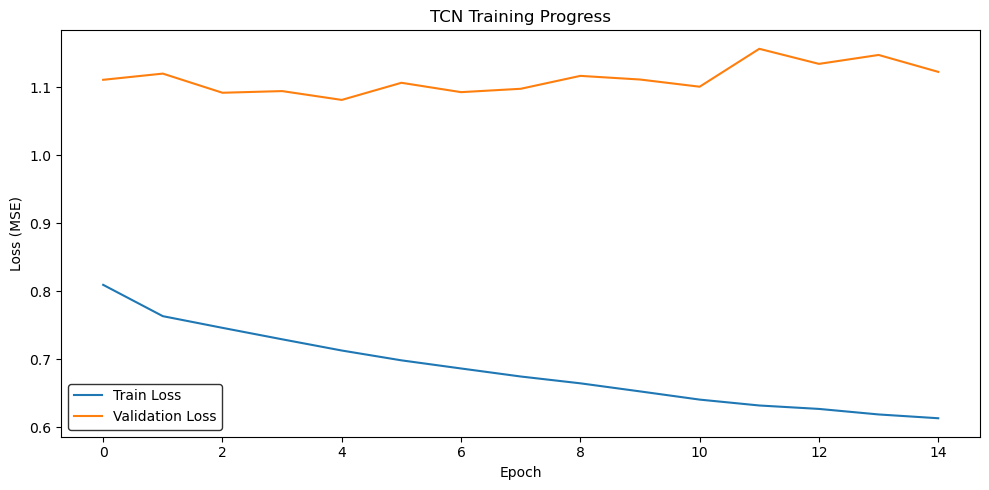

In [5]:
# plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history['train_loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('TCN Training Progress')
ax.legend(frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [6]:
# evaluate model on test set
predictions = trainer.predict(test_loader)

test_targets = []
for _, y in test_loader:
    test_targets.extend(y.numpy())
test_targets = np.array(test_targets)

metrics = calculate_delay_metrics(test_targets, predictions)

print('\nTest Set Metrics (Route Delay Forecasting):')
print(f'  MAE:              {metrics["mae"]:.2f} min')
print(f'  RMSE:             {metrics["rmse"]:.2f} min')
print(f'  Within 15min:     {metrics["within_15"]:.1f}%')
print(f'  Delay Detection:  {metrics["threshold_acc"]:.1f}%')
print(f'  R\u00b2:               {metrics["r2"]:.3f}')


Test Set Metrics (Route Delay Forecasting):
  MAE:              13.10 min
  RMSE:             23.06 min
  Within 15min:     75.1%
  Delay Detection:  81.2%
  R²:               -0.029


## Full Model Comparison

Comparison of all four models on the same test set.

In [7]:
import joblib

# LSTM comparison on same test sequences
lstm_path = '../trained_models/best_lstm_arr_delay.pt'
checkpoint = torch.load(lstm_path, map_location=device, weights_only=False)

lstm_model = RouteDelayLSTM(
    input_size=checkpoint.get('input_size', len(available_features)),
    hidden_size=checkpoint.get('hidden_size', 96),
    num_layers=checkpoint.get('num_layers', 1),
    dropout=checkpoint.get('dropout', 0.14)
)
lstm_model.load_state_dict(checkpoint['model_state_dict'])
lstm_model.to(device)
lstm_model.eval()

lstm_predictions = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        preds = lstm_model(x_batch)
        lstm_predictions.extend(preds.cpu().numpy())
lstm_predictions = np.array(lstm_predictions)
lstm_metrics = calculate_delay_metrics(test_targets, lstm_predictions)

# gradient boosting models aligned to the same test samples as the sequence models
# sequence creation drops the first 28 days per route, so we need to match those indices
from src.config import TABULAR_FEATURES

tabular_features = [c for c in TABULAR_FEATURES if c in df.columns]
target_col = 'avg_arr_delay'

seq_len = config['sequence_length']
aligned_rows = []
for route in test_df['route'].unique():
    rdf = test_df[test_df['route'] == route].sort_values('date')
    aligned_rows.extend(rdf.index[seq_len:])

tree_test_aligned = test_df.loc[aligned_rows]
y_tree_test = tree_test_aligned[target_col].values

xgb_model = joblib.load('../trained_models/xgboost_delay.pkl')
xgb_preds = xgb_model.predict(tree_test_aligned[tabular_features])
xgb_metrics = calculate_delay_metrics(y_tree_test, xgb_preds)

lgb_model = joblib.load('../trained_models/lightgbm_delay.pkl')
lgb_preds = lgb_model.predict(tree_test_aligned[tabular_features])
lgb_metrics = calculate_delay_metrics(y_tree_test, lgb_preds)

print(f'All models evaluated on the same {len(y_tree_test):,} test samples (aligned to sequence windows)')

comparison = pd.DataFrame([
    {'Model': f'XGBoost ({len(tabular_features)} features)', 'MAE (min)': xgb_metrics['mae'], 'RMSE (min)': xgb_metrics['rmse'], 'Within 15min': xgb_metrics['within_15'], 'R\u00b2': xgb_metrics['r2']},
    {'Model': f'LightGBM ({len(tabular_features)} features)', 'MAE (min)': lgb_metrics['mae'], 'RMSE (min)': lgb_metrics['rmse'], 'Within 15min': lgb_metrics['within_15'], 'R\u00b2': lgb_metrics['r2']},
    {'Model': f'TCN ({len(available_features)} features)', 'MAE (min)': metrics['mae'], 'RMSE (min)': metrics['rmse'], 'Within 15min': metrics['within_15'], 'R\u00b2': metrics['r2']},
    {'Model': f'LSTM ({len(available_features)} features)', 'MAE (min)': lstm_metrics['mae'], 'RMSE (min)': lstm_metrics['rmse'], 'Within 15min': lstm_metrics['within_15'], 'R\u00b2': lstm_metrics['r2']},
]).set_index('Model').round(2)

print('\nFull Model Comparison on Test Set (2024-07-01 to 2025-06-30):')
comparison

All models evaluated on the same 16,850 test samples (aligned to sequence windows)

Full Model Comparison on Test Set (2024-07-01 to 2025-06-30):


,MAE (min),RMSE (min),Within 15min,R²
Model,,,,
XGBoost (63 features),10.91,18.81,79.53,0.32
LightGBM (63 features),10.93,18.81,79.35,0.32
TCN (26 features),13.10,23.06,75.11,-0.03
LSTM (26 features),13.10,23.07,75.09,-0.03


## Receptive Field Analysis

With kernel size 4 and depth 4, the receptive field is: `1 + 2*(kernel-1)*sum(2^i for i in range(depth))` = 1 + 2*3*(1+2+4+8) = 91 timesteps. That's 91 >> 28, so the network can see the full input window. The old architecture (kernel=3, depth=3) barely covered it at 29.

In [8]:
# print architecture analysis
print('TCN Architecture Analysis:')
print(f'  Input sequence length: {config["sequence_length"]} days')
print(f'  Receptive field: {model.receptive_field} time steps')
print(f'  Channel progression: {config["num_channels"]}')
print(f'  Kernel size: {config["kernel_size"]}')
print(f'  Dilation factors: {[2**i for i in range(len(config["num_channels"]))]}')

rf_calc = 1 + 2 * (config['kernel_size'] - 1) * sum(2**i for i in range(len(config['num_channels'])))
print(f'  Receptive field (formula): {rf_calc} time steps')

TCN Architecture Analysis:
  Input sequence length: 28 days
  Receptive field: 91 time steps
  Channel progression: [64, 64, 128, 128]
  Kernel size: 4
  Dilation factors: [1, 2, 4, 8]
  Receptive field (formula): 91 time steps


## Summary

TCN and LSTM are essentially identical on this dataset, both landing at 13.10 MAE and a slightly negative R². Both were Optuna-tuned (50 trials each), so neither had an unfair advantage. Despite fundamentally different architectures, the two converge to the same performance level. Both still trail gradient boosting by about 2 minutes of MAE on the aligned test set.

**Next:** [08_error_analysis.ipynb](08_error_analysis.ipynb)